In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

class HMC:
    def __init__(self, x_0, distr, eps, L, M, num_samples=1000):
        self.x_0 = x_0
        self.distr = distr
        self.eps = eps
        self.L = L
        self.M = M
        self.num_samples = num_samples
        self.samples = []
        self.acceptance_rate = 0.0

    def leap_frog(self, x, p):
        M_inv = jnp.linalg.inv(self.M)
        for _ in range(self.L):
            p = p - self.eps / 2 * jax.grad(lambda x: -self.distr(x))(x)
            x = x + self.eps * M_inv @ p
            p = p - self.eps / 2 * jax.grad(lambda x: -self.distr(x))(x)
        return p, x

    def sample(self):
        U = lambda x: -self.distr(x)  # Potential energy function
        x = self.x_0
        accept_count = 0
        samples = []

        for _ in range(self.num_samples):
            p_0 = np.random.multivariate_normal(mean=np.zeros(self.M.shape[0]), cov=self.M)
            p_0 = jnp.array(p_0)

            p, x_new = self.leap_frog(x, p_0)

            M_inv = jnp.linalg.inv(self.M)
            H_new = U(x_new) + 0.5 * p.T @ M_inv @ p
            H_old = U(x) + 0.5 * p_0.T @ M_inv @ p_0

            a = jnp.minimum(1.0, jnp.exp(H_old - H_new))
            s = np.random.uniform(0, 1)

            if s < a:
                x = x_new
                accept_count += 1

            samples.append(x)

        self.samples = jnp.array(samples)
        self.acceptance_rate = accept_count / self.num_samples
        print(f'Acceptance rate: {self.acceptance_rate:.2f}')

    def plot_samples(self):
        if len(self.samples) == 0:
            print("No samples to plot. Run the 'sample' method first.")
            return
        
        plt.figure(figsize=(8, 6))
        plt.plot(self.samples[:, 0], self.samples[:, 1], 'o', alpha=0.6)
        plt.title('HMC Samples')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.grid(True)
        plt.show()

    @property
    def mean(self):
        if len(self.samples) == 0:
            print("No samples to compute mean. Run the 'sample' method first.")
            return None
        return jnp.mean(self.samples, axis=0)

    @property
    def covariance(self):
        if len(self.samples) == 0:
            print("No samples to compute covariance. Run the 'sample' method first.")
            return None
        return jnp.cov(self.samples.T)


Acceptance rate: 1.00
Mean of samples: [ 0.03366777 -0.0014174 ]
Covariance of samples: [[0.9904375  0.00975792]
 [0.00975792 1.0805355 ]]


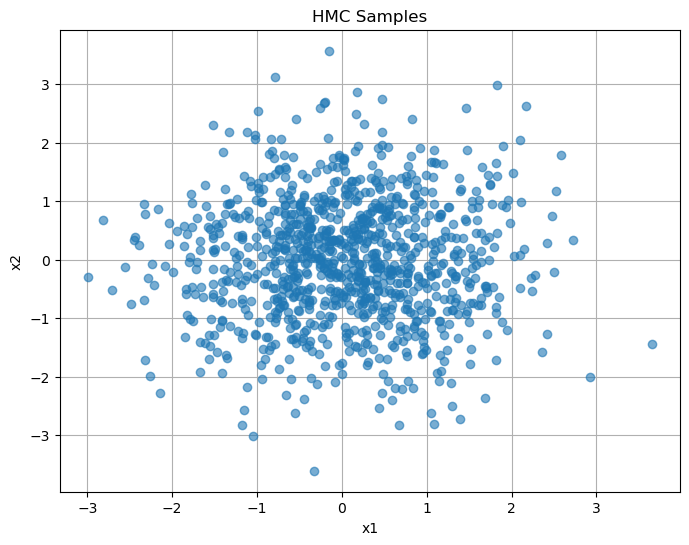

In [2]:
# Example usage
if __name__ == "__main__":
    def target_distribution(x):
        return -0.5 * jnp.dot(x, x)

    initial_position = jnp.array([0.0, 0.0])
    eps = 0.1
    L = 20
    M = jnp.eye(2)
    num_samples = 1000

    hmc_sampler = HMC(initial_position, target_distribution, eps, L, M, num_samples)
    hmc_sampler.sample()
    print("Mean of samples:", hmc_sampler.mean)
    print("Covariance of samples:", hmc_sampler.covariance)
    hmc_sampler.plot_samples()
